In [1]:
# custom layers for both the CNN and the RNN parts of the model. 

Custom CNN Layer
We will create a custom CNN layer to extract features from the images.

In [ ]:
! pip install tensorflow 
! pip install pydot

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, TimeDistributed
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import os
import tensorflow as tf


2024-06-07 14:16:55.252509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:16:56.251217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Preparation
Image Preprocessing

In [4]:
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Embedding, LSTM, add, Input
from tensorflow.keras.models import Model

class CustomCNN(Layer):
    def __init__(self, **kwargs):
        super(CustomCNN, self).__init__(**kwargs)
        self.conv1 = Conv2D(32, (3, 3), activation='relu')
        self.pool1 = MaxPooling2D((2, 2))
        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense = Dense(256, activation='relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

class CustomRNN(Layer):
    def __init__(self, vocab_size, max_length, **kwargs):
        super(CustomRNN, self).__init__(**kwargs)
        self.embedding = Embedding(vocab_size, 256, input_length=max_length, mask_zero=True)
        self.lstm = LSTM(256)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        return x

def define_combined_model(vocab_size, max_length):
    # Image feature extraction model
    inputs1 = Input(shape=(299, 299, 3))
    cnn_out = CustomCNN()(inputs1)
    
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    rnn_out = CustomRNN(vocab_size, max_length)(inputs2)
    
    # Decoder model
    decoder = add([cnn_out, rnn_out])
    decoder = Dense(256, activation='relu')(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder)
    
    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

# model = define_combined_model(vocab_size, max_length)
model = define_combined_model(7378, 34)
model.summary()


2024-06-07 14:16:57.824577: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 349241344 exceeds 10% of free system memory.
2024-06-07 14:16:58.183179: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 349241344 exceeds 10% of free system memory.
2024-06-07 14:16:58.312528: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 349241344 exceeds 10% of free system memory.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_cnn          │ (None, 256)       │ 87,329,984 │ input_layer[0][0] │
│ (CustomCNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_rnn          │ (None, 256)       │  2,414,080 │ input_layer_1[0]… │
│ (CustomRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ custom_cnn[0][0], │
│                     │                   │            │ custom_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7378)      │  1,896,146 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,706,002 (349.83 MB)

 Trainable params: 91,706,002 (349.83 MB)

 Non-trainable params: 0 (0.00 B)

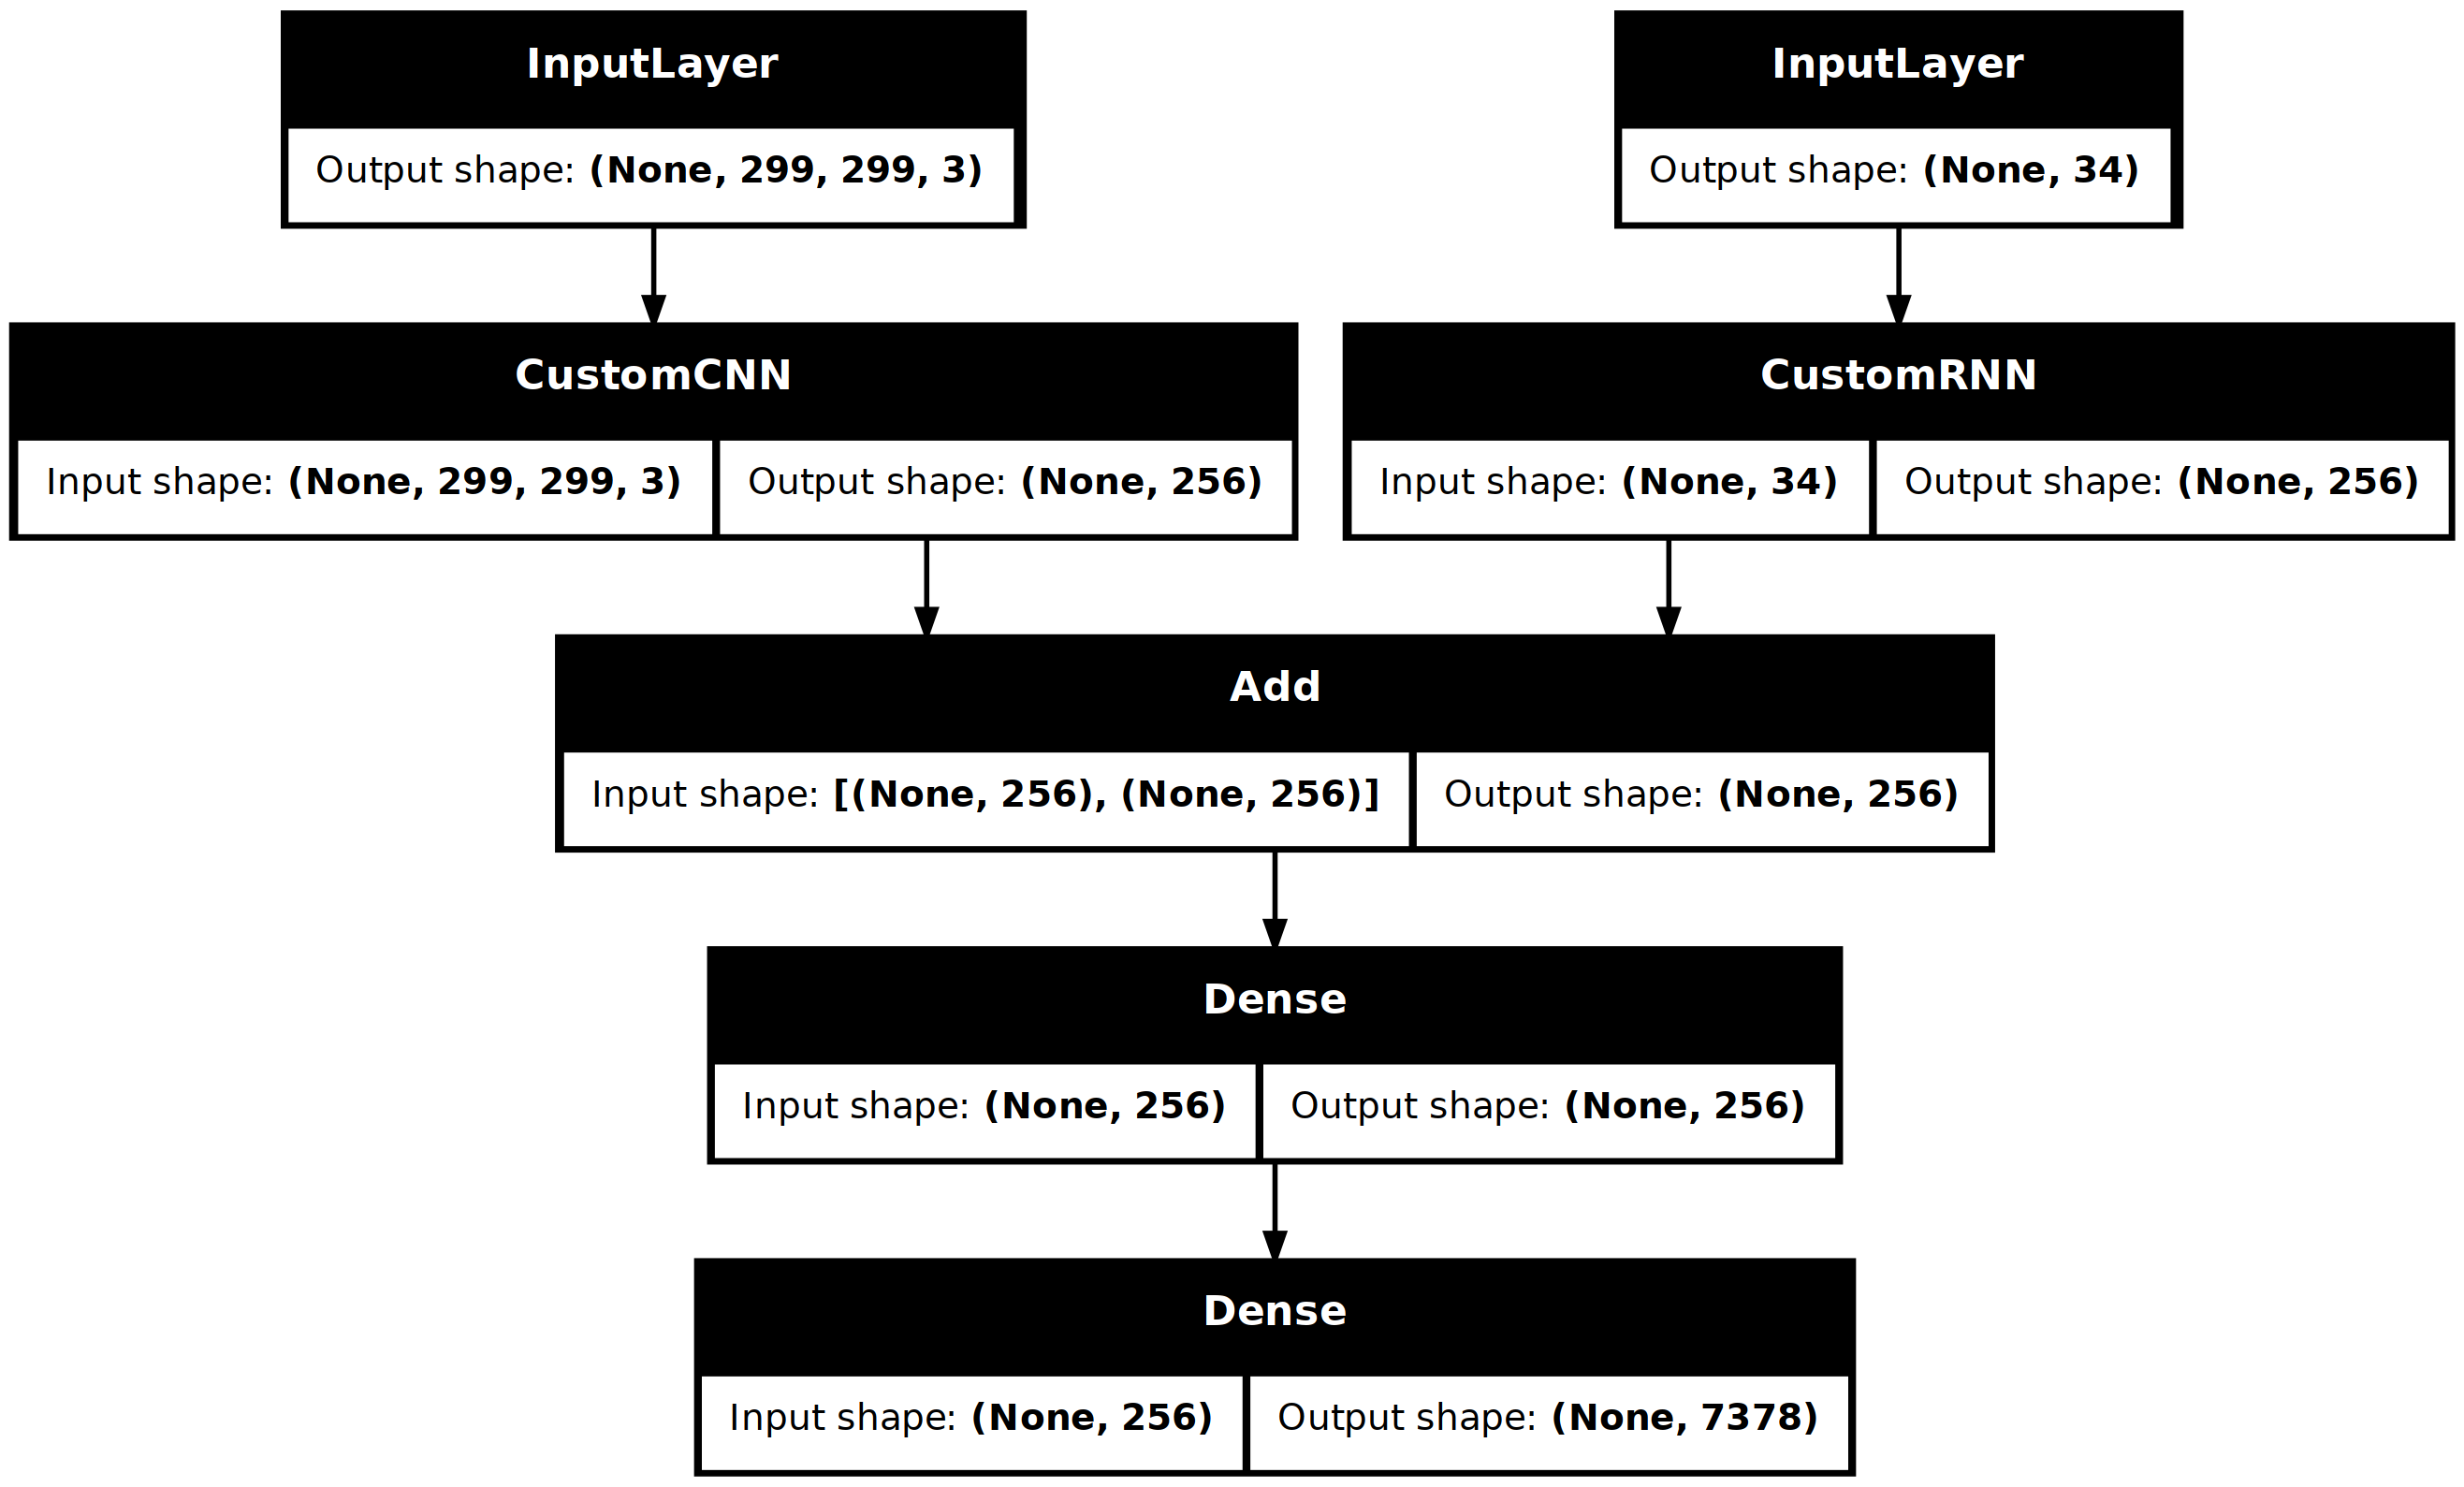

In [5]:
# import tensorflow as tf

tf.keras.utils.plot_model(model,  show_shapes=True)


In [10]:
from classes.dataset_loader import DatasetLoader

current_dir = os.getcwd()
dataset = DatasetLoader().load_data(folder_name=os.path.join(current_dir, 'coco')) 
# datasetloader fatto da cane, 1 squando carichi il DatasetLoader() chiama di default load_data con folder_name = coco... perchè? non ho la possibilità di specificare un altro file path!
# se non c'è la cartella la crea ( commentato bene e apposta)... poi ci legge dentro e Wow non trova il file json :O ... eccezione!
# Non mi chiedere il folder name se poi assumi che la cartella padre sia quella, non è meglio un bel path? magari relativo di default alla cartella os.getcwd()/coco?

# per ora commentato il join dfl_project folder :) e uso direttamente il path, carica 2 volte il dataset




Loading data..
Data loaded succesfully!
Loading data..
Data loaded succesfully!


In [13]:
dataset['annotations']
# [{'image_id': 318556,
#   'id': 48,
#   'caption': 'A very clean and well decorated empty bathroom'},
#  {'image_id': 116100,
#   'id': 67,
#   'caption': 'A panoramic view of a kitchen and all of its appliances.'},
#  {'image_id': 318556,
#   'id': 126,
#   'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
#  {'image_id': 116100,
#   'id': 148,
#   'caption': 'A panoramic photo of a kitchen and dining room'},
#  {'image_id': 379340,

dataset['images'] # the images are in the folder coco/images
# [{'license': 5,
#   'file_name': 'COCO_train2014_000000057870.jpg',
#   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
#   'height': 480,
#   'width': 640,
#   'date_captured': '2013-11-14 16:28:13',
#   'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
#   'id': 57870},
#  {'license': 5,
#   'file_name': 'COCO_train2014_000000384029.jpg',
#   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
#   'height': 429,
#   'width': 640,
#   'date_captured': '2013-11-14 16:29:45',
#   'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
#   'id': 384029},

[{'license': 5,
  'file_name': 'COCO_train2014_000000057870.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 16:28:13',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'id': 57870},
 {'license': 5,
  'file_name': 'COCO_train2014_000000384029.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
  'height': 429,
  'width': 640,
  'date_captured': '2013-11-14 16:29:45',
  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
  'id': 384029},
 {'license': 1,
  'file_name': 'COCO_train2014_000000222016.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000222016.jpg',
  'height': 640,
  'width': 480,
  'date_captured': '2013-11-14 16:37:59',
  'flickr_url': 'http://farm2.staticflickr.com/1431/1118526611_09172475e5_z.jpg',
  'id': 222016},
 {'license': 3

In [15]:
import json
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from classes.dataset_loader import DatasetLoader

# Load the dataset
dataset = DatasetLoader().load_data(folder_name=os.path.join(os.getcwd(), 'coco'))

# Create a mapping from image_id to file_name
image_id_to_file_name = {image['id']: image['file_name'] for image in dataset['images']}

# Create a mapping from image_id to captions
image_id_to_captions = {}
for annotation in dataset['annotations']:
    image_id = annotation['image_id']
    caption = annotation['caption']
    if image_id not in image_id_to_captions:
        image_id_to_captions[image_id] = []
    image_id_to_captions[image_id].append(caption)

# Create a combined dictionary with image file names and their corresponding captions
file_name_to_captions = {image_id_to_file_name[image_id]: captions 
                         for image_id, captions in image_id_to_captions.items()}


Loading data..
Data loaded succesfully!
Loading data..
Data loaded succesfully!


In [16]:
file_name_to_captions

{'COCO_train2014_000000318556.jpg': ['A very clean and well decorated empty bathroom',
  'A blue and white bathroom with butterfly themed wall tiles.',
  'A bathroom with a border of butterflies and blue paint on the walls above it.',
  'An angled view of a beautifully decorated bathroom.',
  'A clock that blends in with the wall hangs in a bathroom. '],
 'COCO_train2014_000000116100.jpg': ['A panoramic view of a kitchen and all of its appliances.',
  'A panoramic photo of a kitchen and dining room',
  'A wide angle view of the kitchen work area',
  'multiple photos of a brown and white kitchen. ',
  'A kitchen that has a checkered patterned floor and white cabinets.'],
 'COCO_train2014_000000379340.jpg': ['A graffiti-ed stop sign across the street from a red car ',
  'A vandalized stop sign and a red beetle on the road',
  'A red stop sign with a Bush bumper sticker under the word stop.',
  'A stop sign that has been vandalized is pictured in front of a parked car.',
  'A street sign 

In [29]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def load_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = preprocess_input(img)
    return img

def data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size):
    while True:
        for file_name, captions in file_name_to_captions.items():
            img_path = os.path.join(image_directory, file_name)
            img = load_image(img_path)
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    yield [img, in_seq], out_seq

def create_tf_data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size),
        output_signature=(
            (tf.TensorSpec(shape=(299, 299, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(max_length,), dtype=tf.int32)),
            tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [35]:
# Set parameters
vocab_size = 10000  # Adjust according to your vocabulary size
max_length = 34     # Adjust according to your max caption length
batch_size = 64

# Tokenize captions
tokenizer = Tokenizer(num_words=vocab_size)
all_captions = [caption for captions in file_name_to_captions.values() for caption in captions]
tokenizer.fit_on_texts(all_captions)

image_directory = 'coco/train2014/'

train_dataset = create_tf_data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size, batch_size)


In [38]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception

def define_model(vocab_size, max_length):
    # Image feature extractor model
    image_input = Input(shape=(299, 299, 3))
    base_model = Xception(include_top=False, pooling='avg')(image_input)
    image_features = Dense(256, activation='relu')(base_model)
    
    # Sequence model
    text_input = Input(shape=(max_length,))
    text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
    text_dropout = Dropout(0.5)(text_embedding)
    text_lstm = LSTM(256)(text_dropout)
    
    # Decoder model
    decoder = add([image_features, text_lstm])
    decoder_dense = Dense(256, activation='relu')(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder_dense)
    
    model = Model(inputs=[image_input, text_input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = define_model(vocab_size, max_length)
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 34, 256)   │  2,560,000 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 2048)      │ 20,861,480 │ input_layer_17[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 34, 256)   │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 34)        │          0 │ input_layer_19[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    524,544 │ xception[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 256)       │    525,312 │ dropout_5[0][0],  │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_78 (Add)        │ (None, 256)       │          0 │ dense_18[0][0],   │
│                     │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ add_78[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 10000)     │  2,570,000 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,107,128 (103.41 MB)

 Trainable params: 27,052,600 (103.20 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [37]:
steps = len(file_name_to_captions) // batch_size
model.fit(train_dataset, epochs=20, steps_per_epoch=steps, verbose=1)


Epoch 1/20


ValueError: Layer 'functional_11' expected 2 input(s). Received 1 instead.

In [41]:
from data_loader import get_loader
from pycocotools.coco import COCO
from torchvision import transforms

# Amend the image transform below.
transform_train = transforms.Compose(
    [
        # smaller edge of image resized to 256
        transforms.Resize(256),
        # get 224x224 crop from random location
        transforms.RandomCrop(224),
        # horizontally flip image with probability=0.5
        transforms.RandomHorizontalFlip(),
        # convert the PIL Image to a tensor
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
make 

In [43]:

# Build data loader.
data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=5,
    vocab_from_file=False,
    cocoapi_loc="",
)

loading annotations into memory...


FileNotFoundError: [Errno 2] No such file or directory: 'cocoapi/annotations/captions_train2014.json'